<a href="https://colab.research.google.com/github/jkurian49/Neural-Style-Transfer/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code adapted from TensorFlow documentation found at:
https://www.tensorflow.org/tutorials/generative/style_transfer




# Setup



## Import Packages and Load Images

In [ ]:
!git clone https://github.com/jkurian49/Neural-Style-Transfer.git
import os
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import time
import functools
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

fatal: destination path 'Neural-Style-Transfer' already exists and is not an empty directory.


In [ ]:
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

## Image Helper Functions

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.axis('off')
  plt.imshow(image)
  if title:
    plt.title(title)

# Fast Style Transfer Using TF-Hub

## Define Content and Style Representations

In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 229, 512, 64)
  min:  0.0
  max:  619.0708
  mean:  27.540329

block2_conv1
  shape:  (1, 114, 256, 128)
  min:  0.0
  max:  2054.8667
  mean:  160.64189

block3_conv1
  shape:  (1, 57, 128, 256)
  min:  0.0
  max:  6916.1885
  mean:  168.53473

block4_conv1
  shape:  (1, 28, 64, 512)
  min:  0.0
  max:  9964.101
  mean:  548.6505

block5_conv1
  shape:  (1, 14, 32, 512)
  min:  0.0
  max:  2188.9758
  mean:  36.840034



In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

## Run Style Transfer on All Images

In [ ]:
## Retrieve Capitol images and tapestry images
directory = "/content/Neural-Style-Transfer"
capitol_files, tapestry_files = [],[]
for capitol_file in os.listdir(directory+"/capitol_riot_images"):
  if capitol_file.endswith(".jpg"):
    capitol_files.append(capitol_file)
for tapestry_file in os.listdir(directory+"/tapestries"):
  if tapestry_file.endswith(".jpg"):
    tapestry_files.append(tapestry_file)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
# @tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

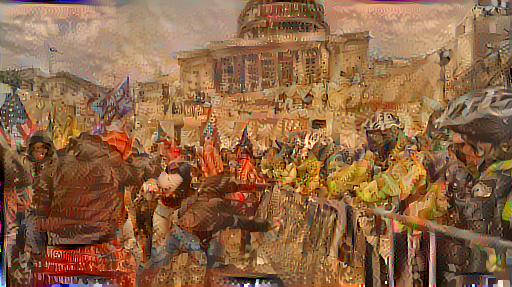

Train step: 1000


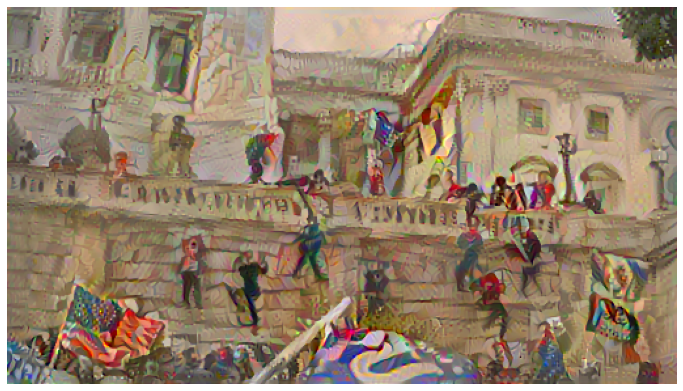

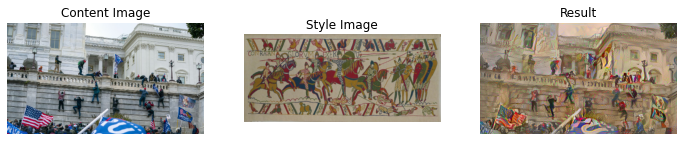

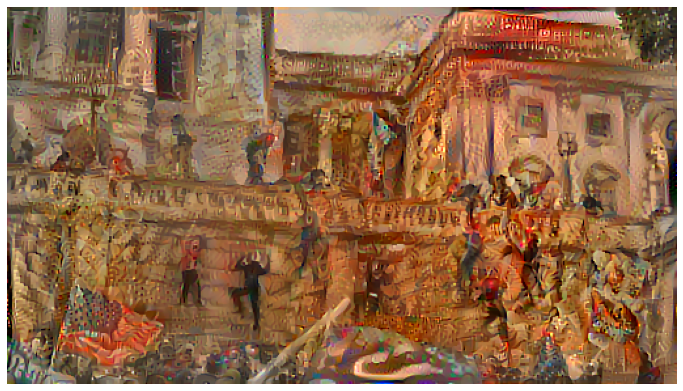

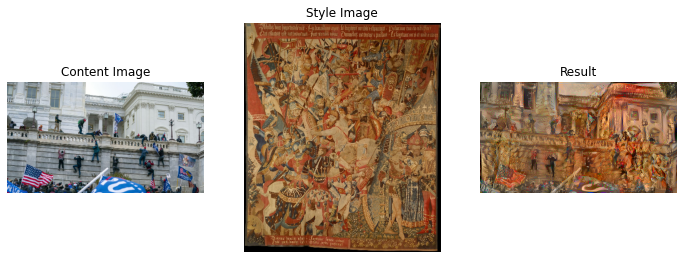

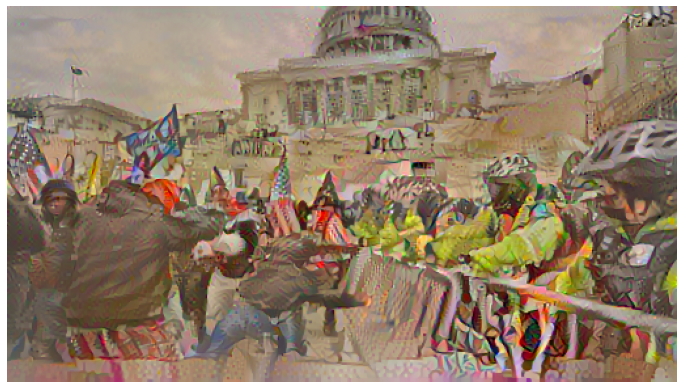

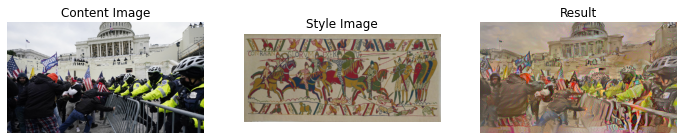

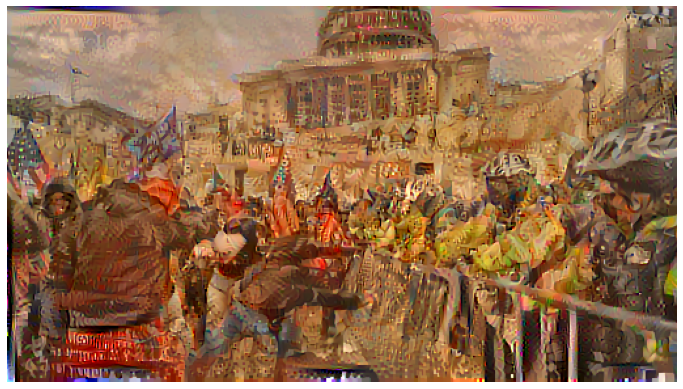

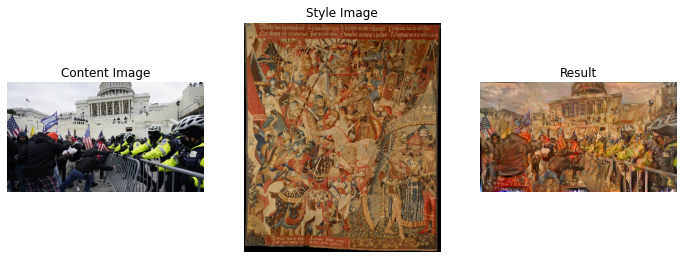

In [ ]:
## Run style transfer  on all possible combinations of style and content images
extractor = StyleContentModel(style_layers, content_layers)
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4
total_variation_weight = 30
epochs = 10
steps_per_epoch = 100
for capitol_file in capitol_files:
  for tapestry_file in tapestry_files:
    content_image = load_img(os.path.join(directory,"capitol_riot_images",capitol_file))
    style_image = load_img(os.path.join(directory,"tapestries",tapestry_file))
    results = extractor(tf.constant(content_image))
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']
    image = tf.Variable(content_image)
    step = 0
    for n in range(epochs):
      for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
        display.clear_output(wait=True)
        display.display(tensor_to_image(image))
        print("Train step: {}".format(step))

    ## Save Results
    save_path = directory+"/results/"+os.path.splitext(capitol_file)[0]\
                            +"_"+os.path.splitext(tapestry_file)[0]
    plt.figure()
    imshow(image)
    plt.savefig(save_path+".jpg")
    plt.figure()
    plt.subplot(1, 3, 1)
    imshow(content_image, 'Content Image')

    plt.subplot(1, 3, 2)
    imshow(style_image, 'Style Image')

    plt.subplot(1, 3, 3)
    imshow(image, 'Result')
    plt.savefig(save_path+"_Comparison.jpg")